# Pygmalion - Projet autocomplétion

**Sprint 4 : Transformers**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DataScientest-Studio/Pygmalion/blob/main/notebooks/4-Transformers.ipynb)

Certaines parties ne fonctionnent pas dans Google Colab.

## I. Data loading and preprocessing

Montage du disque et import des packages

In [ ]:
# To import libraries that's not in Colaboratory by default
!pip install datasets
!pip install transformers

In [1]:
# Import des packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
from joblib import dump, load
import time
from nltk.tokenize.regexp import RegexpTokenizer
from string import ascii_lowercase
from tqdm.notebook import tqdm
import random

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import pickle
import gzip

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RNN, Lambda, Embedding, GlobalAveragePooling1D


import unicodedata
import re
import os
import io
import time

from datasets import Dataset

import time
import joblib

from transformers import GPT2Tokenizer, GPT2TokenizerFast, BertTokenizerFast, AutoTokenizer, AlbertTokenizer
from transformers import DefaultDataCollator

from transformers import AutoConfig, TFAutoModelForCausalLM
from transformers import TFGPT2LMHeadModel

from transformers import AdamWeightDecay

from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adrie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adrie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Activez le GPU dans google colab
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Necessaire pour sauvegarder les données sur google drive (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Indiquez le dossier de sauvegarde de vos fichiers
path = '/content/drive/MyDrive/Pygmalion/'
path=r'C:\Users\adrie\Mon Drive\Pygmalion2'

Chargement du Dataset ENRON

In [4]:
# Chargement du dataframe à partir de google drive
# Le dataset est préparé dans le fichier 1-Exploration_des_données_et_DataViz
file = os.path.join(path, 'df_emails.csv')
df_emails = pd.read_csv(file)

### General functions

In [5]:
def save_object(obj, filename, zip=False):
    if zip:
        with gzip.open(filename,'wb') as outp:
            pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    else:
        with open(filename, 'wb') as outp:
            pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
            
def load_object(filename, zip=False):
    if zip:
        with gzip.open(filename,'rb') as inp:
            return pickle.load(inp)
    else:
        with open(filename, 'rb') as inp:
            return pickle.load(inp)
        
def write_data(filepath, lines):
    with open(filepath,'a', newline='\n') as fd:
        writer = csv.writer(fd)
        writer.writerows(lines)
        
def read_data(filepath):
    lines = []
    with open(filepath, newline='\n') as fd:
        reader = csv.reader(fd)
        for row in reader:
            lines.append(row)
        return lines

#### Content cleaning and dataset creation

In [6]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def split(delimiters, string, maxsplit=0):
    import re
    regexPattern = '|'.join(map(re.escape, delimiters))
    return re.split(regexPattern, string, maxsplit)

delimiters = ["!",".",";","?"]

def sentences_from_df(df, size_min=4):
    sentences = []
    # lecture ligne par ligne
    print("Cleaning of dataframe")
    with tqdm(total = len(df)) as pbar:
        for l in df:
            # nettoyage de la phase
            l = unicode_to_ascii(l.lower())
            l = re.sub(r"([?!,¿])", r" \1 ", l)
            l = re.sub(r'[" "]+', " ", l)
            
            # decontraction
            l = re.sub(r"won't", "will not", l)
            l = re.sub(r"can\'t", "can not", l)
            l = re.sub(r"n\'t", " not", l)
            l = re.sub(r"\'re", " are", l)
            #l = re.sub(r"\'s", " is", l) # Très souvent, 's est la marque du possessif
            l = re.sub(r"\'d", " would", l)
            l = re.sub(r"\'ll", " will", l)
            l = re.sub(r"\'t", " not", l)
            l = re.sub(r"\'ve", " have", l)
            l = re.sub(r"\'m", " am", l)
            
            # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
            l = re.sub(r"[^a-z?.!;]+", " ", l)
        
            for s in split(delimiters, l):
                if len(s.split())>=size_min:
                    sentences.append(" ".join(s.split()))
            pbar.update(1)
    return sentences

In [7]:
%%time
mail_max = -1
sentences = sentences_from_df(df_emails["content"].iloc[:mail_max])

Cleaning of dataframe


  0%|          | 0/517400 [00:00<?, ?it/s]

Wall time: 3min 8s


In [10]:
if not os.path.isdir(os.path.join(path, "Transformer", "")):
    os.mkdir(os.path.join(path, "Transformer", ""))

In [11]:
# Save the sentences list
file = os.path.join(path, "Transformer", "sentences.gz")
save_object(sentences, file, zip=True)

In [12]:
# Load the sentences list
file = os.path.join(path, "Transformer", "sentences.gz")
sentences = load_object(file, zip=True)

In [13]:
df = pd.DataFrame(sentences, columns=["text"])

In [14]:
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.1, seed = 42)

In [15]:
def batch_iterator(dataset, batch_size=1000):
    for i in range(0, len(dataset["train"]), batch_size):
        yield dataset["train"][i : i + batch_size]["text"]

In [16]:
def df_for_transformer(dataset, ngram, num_examples):
    df = []
    for s in dataset[0:num_examples]["text"]:
        for w in range(len(s.split(' '))):
            splitat = w
            left = ' '.join(s.split(' ')[max(0,splitat-ngram):splitat])
            right = ' '.join(s.split(' ')[splitat:splitat+1])
            df.append([s, left, right])
    df = pd.DataFrame(df).rename({0: 'sentences', 1:'entry', 2:'prediction'},axis=1)
    return df

def tokenize_df(df, column, num_words, tokenizer=None):
        # tokenization des phrases
        if tokenizer == None:
            tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words)
            tokenizer.fit_on_texts(df["sentences"])
        # transformation des phrases en séquences
        seq = tokenizer.texts_to_sequences(df[column])
        # ajout des tokens de début et fin de séquence
        seq = [[num_words] + s + [num_words+ 1] for s in seq]
        return seq, tokenizer        

## II. Modèle Transformer

### a. Définition des classes

#### Multihead Attention

In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension of x into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)        
        """
        # Reshaping is used to perform the split
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        output = tf.transpose(x, perm=[0, 2, 1, 3])   
        
        return output

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # Apply dense matrices to Q, K and V
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # Split the vectors using the split_heads function defined above
        q = self.split_heads(q, batch_size) 
        k = self.split_heads(k, batch_size) 
        v = self.split_heads(v, batch_size) 

        # Compute the masked scaled dot product attention on Q, K, V
        scaled_attention, attention_weights = self.scaled_dot_product_attention(
            q, k, v, mask)

        # Concatenate the attention heads by reshaping the tensor
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))
        
        # Apply the dense matrix wo to the output
        output = self.dense(concat_attention)

        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        """Calculate the attention weights.

        Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor

        Returns:
        output, attention_weights
        """
        
        # Get dk the dimension of the keys
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        
        # Compute dot products 
        dot_products = tf.matmul(q, k, transpose_b=True)
        
        # Scale dot products
        scaled_dot_products = dot_products / tf.math.sqrt(dk)

        # Apply mask
        if mask is not None:
            # Multiply mask by -1e10 (almost infinity)a
            mask = mask * (-1e10)
            
            # Sum dot products with mask
            scaled_dot_products = scaled_dot_products + mask
        
        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(scaled_dot_products)
        
        # Get the attention vector
        attention_vector = tf.matmul(attention_weights, v)

        return attention_vector, attention_weights


#### Encoder

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = tf.keras.models.Sequential()
        self.ffn.add(tf.keras.layers.Dense(dff, activation='relu'))
        self.ffn.add(tf.keras.layers.Dense(d_model))

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # Step 1
        A, _ = self.mha(x, x, x, mask)
        
        # Step 2
        A = self.dropout1(A, training=training)
        
        # Step 3
        x = A + x
        
        # Step 4
        x = self.layernorm1(x)
        
        # Step 5
        O = self.ffn(x)
        
        # Step 6
        O = self.dropout2(O)
        
        # Step 7
        x = O + x
        
        # Step 8
        output = self.layernorm2(x)
        
        return output

In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        """
        num_layers : Number of Encoding layers in the Encoder.
        
        d_model : Dimensionality of the embedding layer's output.
        
        num_heads : Number of attention heads in the Multi-Head Attention layers.
        
        dff : Number of neurons in the first layer of the Feed Forward Network in the Encoding layers.
        
        input_vocab_size : Size of the vocabulary the embedding layer should train on.
        
        maximum_position_encoding : Maximum number of tokens in a sequence.
        
        rate : Dropout rate in the Encoding layers.      
        
        """
        super(Encoder, self).__init__()

        self.d_model = d_model
        
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        
        seq_len = tf.shape(x)[1]
        
        # Generate Embedding
        x = self.embedding(x) 

        # Add Positional Encoding
        x += self.pos_encoding[:, :seq_len, :]

        # Apply Dropout
        x = self.dropout(x, training=training)

        # Apply Encoding Layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x 

#### Decoder

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """        
        d_model : Dimensionality of the embedding layer's output.
        
        num_heads : Number of attention heads in the Multi-Head Attention layers.
        
        dff : Number of neurons in the first layer of the Feed Forward Network in the Decoding layers.
        
        rate : Dropout rate in the Decoding layers.      
        """
        
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = tf.keras.models.Sequential()
        self.ffn.add(tf.keras.layers.Dense(dff, activation='relu'))
        self.ffn.add(tf.keras.layers.Dense(d_model))

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        x : Input Tensor of the embeddings of the partially translated sentence.
        
        enc_output : Output Tensor of the Decoder.
        
        training : Whether the model is training or not so that Dropout is only applied during training.
        
        look_ahead_mask : Tensor for masking tokens that have not been translated yet.
        
        padding_mask : Tensor masking padding tokens of the Decoder's input.      
        """

        A1, _  = self.mha1(x, x, x, look_ahead_mask)
        A1     = self.dropout1(A1, training=training)
        x      = A1 + x
        x      = self.layernorm1(x)

        A2, _  = self.mha2(enc_output, enc_output, x, padding_mask)
        A2     = self.dropout2(A2, training=training)
        x      = A2 + x
        x      = self.layernorm2(x) 

        O      = self.ffn(x) 
        O      = self.dropout3(O, training=training)
        x      = O + x
        Output = self.layernorm3(x) 

        return Output

In [21]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        """
        num_layers : Number of Decoding layers in the Decoder.
        
        d_model : Dimensionality of the embedding layer's output.
        
        num_heads : Number of attention heads in the Multi-Head Attention layers.
        
        dff : Number of neurons in the first layer of the Feed Forward Network in the Decoding layers.
        
        target_vocab_size : Size of the vocabulary the embedding layer should train on.
        
        maximum_position_encoding : Maximum number of tokens in a sequence.
        
        rate : Dropout rate in the Decoding layers.      
        """
        
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        x : Input Tensor of the partially translated sentence.
        
        enc_output : Output Tensor of the Encoder.
        
        training : Whether the model is training or not so that Dropout is only applied during training.
        
        look_ahead_mask : Tensor for masking tokens that have not been translated yet.
        
        padding_mask : Tensor masking padding tokens of the Decoder's input.      
        """
        seq_len = tf.shape(x)[1]
        
        # Generate Embedding
        x = self.embedding(x) 

        # Add Positional Encoding
        x += self.pos_encoding[:, :seq_len, :]

        # Apply Dropout
        x = self.dropout(x, training=training)

        # Apply Decoding Layers
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training,
                                   look_ahead_mask, padding_mask)

        return x 

#### Transformer

In [22]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        """
        num_layers : Number of Encoding/Decoding layers in the Encoder/Decoder.
        d_model    : Dimensionality of the embedding layers' output.
        num_heads  : Number of attention heads in the Multi-Head Attention layers.
        dff        : Number of neurons in the first layer of the Feed Forward Network in the Encoding/Decoding layers.
        rate       : Dropout rate in the Encoding/Decoding layers.    
        
        input_vocab_size  : Size of the vocabulary the Encoder's embedding layer should train on.
        target_vocab_size : Size of the vocabulary the Encoder's embedding layer should train on.
        
        
        pe_input  : Maximum number of tokens in the input sequence of the Encoder.
        pe_target : Maximum number of tokens in the input sequence of the Decoder.
        """       
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation = 'softmax')
    
    def call(self, encoder_input, decoder_input ,training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        """
        encoder_input : Input Tensor of the original sentence to be given to the Encoder.
        decoder_input : Input Tensor of the partially translated sentence to be given to the Decoder.
        
        training : Whether the model is training or not so that Dropout is only applied during training.
        
        enc_padding_mask : Tensor masking padding tokens of the Encoder's input.
        look_ahead_mask  : Tensor for masking tokens that have not been translated yet.
        dec_padding_mask : Tensor masking padding tokens of the Decoder's input.      
        """

        # Get Encoder Output
        enc_output = self.encoder(encoder_input, training, enc_padding_mask)

        # Get Decoder Output
        dec_output = self.decoder(decoder_input, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # Perform Classification
        final_output = self.final_layer(dec_output)

        return final_output

#### Fonctions de positionnement

In [23]:
def positional_encoding(position_max, d_model):
    i = np.linspace(0, d_model-1, d_model)
    
    pos_encoding = np.zeros((position_max, d_model))
    
    for pos, row in enumerate(pos_encoding):
        pos_encoding[pos, ::2] = np.sin(pos/(10000 ** (i[::2]/d_model)))
        pos_encoding[pos, 1::2] = np.cos(pos/(10000 ** ((i[1::2]-1)/d_model))) 
    
    return tf.cast(pos_encoding.reshape(1, position_max, d_model), dtype = tf.float32)

### b. Entraînement du modèle

#### Paramètres du modèle

In [24]:
NUM_MAILS=100000
NUM_WORDS=40000
NPRED = NUM_WORDS+2
MAX_LENGTH=40
NGRAMS = MAX_LENGTH
EPOCHS = 1
TOP_RECALCUL = True

#### Preparation du dataset

In [25]:
# Instanciation du dataset Train
df = df_for_transformer(dataset["train"], ngram=NGRAMS, num_examples=NUM_MAILS)

# Tokenisation
sequences = {}
sequences["entry"], tokenizer_transformer = tokenize_df(df, "entry", num_words=NUM_WORDS)
sequences["prediction"], tokenizer_transformer = tokenize_df(df, "prediction", num_words=NUM_WORDS, tokenizer=tokenizer_transformer)

# Filtre des longueurs
X, Y = [], []
for x, y in zip(sequences["entry"], sequences["prediction"]):
    if len(x) <= MAX_LENGTH and len(y) <= MAX_LENGTH:
        X.append(x)
        Y.append(y)
sequences["entry"] = X        
sequences["prediction"] = Y
        
# Padding
for c in ["entry", "prediction"]:
    sequences[c] = tf.keras.preprocessing.sequence.pad_sequences(sequences[c], padding='post')

# Constitution du dataset TENSORFLOW
train_dataset = tf.data.Dataset.from_tensor_slices((sequences['entry'], sequences['prediction'])).batch(64)
len_dataset = len(sequences['entry'])

In [26]:
lengths_fr = []
lengths_en = []

for x, y in zip(sequences["entry"], sequences["prediction"]):
    lengths_fr.append(len(sequences["entry"]))
    lengths_en.append(len(sequences["prediction"]))
    
print("Longueur maximale entry:", max(lengths_fr))
print("Longueur maximale prediction:", max(lengths_en))
print()
print("Taille Corpus entry:", len(sequences["entry"]))
print("Taille Corpus prediction:", len(sequences["prediction"]))

Longueur maximale entry: 1648981
Longueur maximale prediction: 1648981

Taille Corpus entry: 1648981
Taille Corpus prediction: 1648981


In [27]:
# Instanciation du dataset test
df_test = df_for_transformer(dataset["test"], ngram=NGRAMS, num_examples=int(NUM_MAILS/10))

# Tokenisation
sequences_test, tokenizers_test = {}, {}
for c in ["entry", "prediction"]:
    sequences_test[c], tokenizer_transformer = tokenize_df(df_test, c, num_words=NUM_WORDS, tokenizer=tokenizer_transformer)
    
# Filtre des longueurs
X, Y = [], []
for x, y in zip(sequences_test["entry"], sequences_test["prediction"]):
    if len(x) <= MAX_LENGTH and len(y) <= MAX_LENGTH:
        X.append(x)
        Y.append(y)
sequences_test["entry"] = X        
sequences_test["prediction"] = Y
        
# Padding
for c in ["entry", "prediction"]:
    sequences_test[c] = tf.keras.preprocessing.sequence.pad_sequences(sequences_test[c], padding='post')

# Constitution du dataset TENSORFLOW
test_dataset = tf.data.Dataset.from_tensor_slices((sequences_test['entry'], sequences_test['prediction'])).batch(64)

In [28]:
lengths_fr = []
lengths_en = []

for x, y in zip(sequences_test["entry"], sequences_test["prediction"]):
    lengths_fr.append(len(sequences_test["entry"]))
    lengths_en.append(len(sequences_test["prediction"]))
    
print("Longueur maximale entry:", max(lengths_fr))
print("Longueur maximale prediction:", max(lengths_en))
print()
print("Taille Corpus entry:", len(sequences_test["entry"]))
print("Taille Corpus prediction:", len(sequences_test["prediction"]))

Longueur maximale entry: 166591
Longueur maximale prediction: 166591

Taille Corpus entry: 166591
Taille Corpus prediction: 166591


In [30]:
# Save the dataset on drive
file = os.path.join(path, "Transformer", "train_dataset", "")
tf.data.experimental.save(train_dataset, file, compression="GZIP")
file = os.path.join(path, "Transformer", "test_dataset", "")
tf.data.experimental.save(test_dataset, file, compression="GZIP")

tokenizer_json = tokenizer_transformer.to_json() # Save Tokenizer to json format
file = os.path.join(path, "Transformer", "tokenizer_json.gz")
save_object(tokenizer_json, file, zip=True)

In [31]:
# Load the dataset from drive
file = os.path.join(path, "Transformer", "train_dataset", "")
train_dataset = tf.data.experimental.load(file, compression="GZIP")
file = os.path.join(path, "Transformer", "test_dataset", "")
test_dataset = tf.data.experimental.load(file, compression="GZIP")

file = os.path.join(path, "Transformer", "tokenizer_json.gz")
tokenizer_json = load_object(file, zip=True)
tokenizer_transformer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)

#### Initialisation

In [32]:
num_layers = 1
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_transformer.num_words + 2
target_vocab_size = tokenizer_transformer.num_words + 2
dropout_rate = 0.1


transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
# Gros transformer
num_layers = 2
d_model = 256
dff = 512
num_heads = 16

input_vocab_size = tokenizer_transformer.num_words + 2
target_vocab_size = tokenizer_transformer.num_words + 2
dropout_rate = 0.1


transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

#### Masques

In [33]:
# Création des masques
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

# Création du masque Look Ahead
def create_look_ahead_mask(MAX_LENGTH):
    mask = 1 - tf.linalg.band_part(tf.ones((MAX_LENGTH, MAX_LENGTH)), -1, 0)
    return mask  # (MAX_LENGTH, MAX_LENGTH)

# Création du masque de padding
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

#### Fonction de coût

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def loss_function(real, pred):
    valid_tokens = tf.math.logical_not(tf.math.equal(real, 0))
    # if real != 0 -> valid_tokens = True This is used to mask padded outputs

    
    loss_ = loss_object(real, pred)
  
    valid_tokens = tf.cast(valid_tokens, dtype=loss_.dtype)#cast valid_tokens to the same type as loss_
    loss_ = tf.reduce_sum(loss_*valid_tokens)/tf.reduce_sum(valid_tokens)
  
    return loss_

#### Optimiseur

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [36]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

#### Entraînement

In [37]:
# Serviront à l'affichage pendant l'entraînement
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions = transformer(inp, 
                                  tar_inp,
                                  True, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

#### Validation

In [38]:
# Serviront à l'affichage pendant l'entraînement
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='val_accuracy')

val_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=val_step_signature)
def val_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions = transformer(inp, 
                                  tar_inp,
                                  False, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    val_loss(loss)
    val_accuracy(tar_real, predictions)

#### Affichage des paramètres du modèle

In [39]:
params = {'NUM_MAILS':NUM_MAILS,
         'NUM_WORDS':NUM_WORDS,
         'NPRED': NPRED,
         'MAX_LENGTH':MAX_LENGTH,
         'NGRAMS':NGRAMS,
         'EPOCHS':EPOCHS,
         'num_layers': num_layers,
         'd_model':d_model,
         'dff':dff,
         'num_heads':num_heads,
         'dropout_rate':dropout_rate}
file = os.path.join(path, "Transformer", "param.obj")
save_object(params, file, zip=False)
params

{'NUM_MAILS': 100000,
 'NUM_WORDS': 40000,
 'NPRED': 40002,
 'MAX_LENGTH': 40,
 'NGRAMS': 40,
 'EPOCHS': 1,
 'num_layers': 1,
 'd_model': 128,
 'dff': 512,
 'num_heads': 8,
 'dropout_rate': 0.1}

In [40]:
loss = []
accuracy = []
loss_validation=[]
accuracy_validation=[]

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    with tqdm(total = int(len_dataset/64)+1) as pbar:
        for (batch, (inp, tar)) in enumerate(train_dataset):
            train_step(inp, tar)

            if batch>0 and batch % (NUM_MAILS/10) == 0:
                print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                  epoch + 1, batch, train_loss.result(), train_accuracy.result()))
            pbar.update(1)

    for (batch, (inp, tar)) in enumerate(test_dataset):
        val_step(inp, tar)
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f} Val_loss {:.4f} Val_accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result(),
                                                val_loss.result(),
                                                val_accuracy.result()
                                                        ))
    loss.append(train_loss.result())
    accuracy.append(train_accuracy.result())
    loss_validation.append(val_loss.result())
    accuracy_validation.append(val_accuracy.result())
    
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

  0%|          | 0/25766 [00:00<?, ?it/s]

Epoch 1 Batch 10000 Loss 3.8406 Accuracy 0.5255
Epoch 1 Batch 20000 Loss 3.7017 Accuracy 0.5357
Epoch 1 Loss 3.6987 Accuracy 0.5389 Val_loss 3.6199 Val_accuracy 0.5503
Time taken for 1 epoch: 626.732860326767 secs



In [41]:
# Save the weight
pathTmodel = os.path.join(path, "Transformer", "model_transformer", "")
transformer.save_weights(pathTmodel)

In [42]:
# Load the parameters
file = os.path.join(path, "Transformer", "param.obj")
params = load_object(file, zip=False)
NUM_MAILS = params['NUM_MAILS']
NUM_WORDS = params['NUM_WORDS']
NPRED = params['NPRED']
MAX_LENGTH = params['MAX_LENGTH']
NGRAMS = params['NGRAMS']
EPOCHS = params['EPOCHS']
num_layers = params['num_layers']
d_model = params['d_model']
dff = params['dff']
num_heads = params['num_heads']
dropout_rate = params['dropout_rate']

In [43]:
# Load the tokenizer
file = os.path.join(path, "Transformer", "tokenizer_json.gz")
tokenizer_json = load_object(file, zip=True)
tokenizer_transformer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)

input_vocab_size = tokenizer_transformer.num_words + 2
target_vocab_size = tokenizer_transformer.num_words + 2

In [44]:
# Transformer creation and load the weights
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)
pathTmodel = os.path.join(path, "Transformer", "model_transformer", "")
transformer.load_weights(pathTmodel)

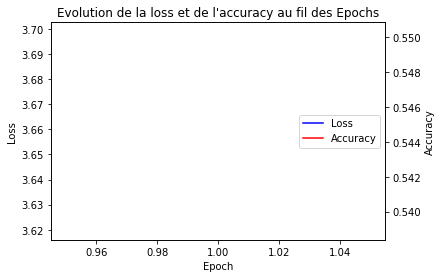

In [45]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title("Evolution de la loss et de l'accuracy au fil des Epochs")
x_epochs = range(1, len(loss)+1)
lns1 = ax1.plot(x_epochs, loss, 'b', label='Loss')
lns2 = ax2.plot(x_epochs, accuracy, 'r', label='Accuracy')

lns3 = ax1.plot(x_epochs, loss_validation, 'b--', label='Loss validation')
lns4 = ax2.plot(x_epochs, accuracy_validation, 'r--', label='Accuracy validation')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=7)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

plt.show();

### c. Prédiction

In [46]:
def evaluate(inp_sentence, tokenizer, transformer):
    start_token = [tokenizer.num_words]
    end_token = [tokenizer.num_words + 1]
    
    
    # Encodage de la phrase, en rajoutant les tokens de debut 
    # et de fin du vocabulaire
    encoder_input = start_token + tokenizer.texts_to_sequences([inp_sentence])[0] + end_token
    
    # Conversion de la liste en tensor de shape (1, seq_len + 2)
    encoder_input = tf.expand_dims(encoder_input, 0)

    # initialisation de la prédiction partielle avec le token 
    # de debut du vocabulaire anglais
    decoder_input = start_token
    # Conversion de la liste en tensor de shape (1, 1) 
    # pour pouvoir appliquer le transformer dessus
    output = tf.expand_dims(decoder_input, 0)

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

    # predictions est la nouvelle prédiction partielle
    predictions = transformer(encoder_input,
                                output,
                                False,
                                enc_padding_mask,
                                combined_mask,
                                dec_padding_mask)

    # on récupère les probabilités pour le dernier mot prédit
    # puis l'id du mot le plus probable
    next_words = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
    return tf.squeeze(next_words, axis=0).numpy()

def predict_next_word_df_transformer(sentence, tokenizer, transformer, n_word=1, startwith='', list_tokens=None, format_list=False):
    #Preparation de la liste de mots
    if list_tokens == None:
        list_tokens = [None]*tokenizer.num_words
        for i in range(0,tokenizer.num_words):
            list_tokens[i]=tokenizer.sequences_to_texts([[i]])
        list_tokens = [item for sublist in list_tokens for item in sublist]
        list_tokens.append("<START>")
        list_tokens.append("<END>")
    
    pred = evaluate(sentence, tokenizer, transformer)
    result = pd.DataFrame({"Proba":pred[0],"Word":list_tokens})
    #result.drop(result.tail(2).index,inplace=True) #Remove <START> AND <STOP>
    result = result[result["Word"].str.startswith(startwith)]
    result = result.sort_values(by="Proba", ascending=False).head(n_word)
    if format_list:
        result = result["Word"].tolist()
    return result

In [47]:
sentence = dataset["test"][8]["text"]
print(sentence)
sentence = "checkout bloomberg deal sent over a confirmation for a deal"
predict_next_word_df_transformer(sentence, tokenizer_transformer, transformer, n_word=5, startwith='', list_tokens=None, format_list=False)

checkout bloomberg deal bloomberg sent over a confirmation for a deal where enron buys from williams mw np at


,Proba,Word
4,0.089246,of
3,0.070856,and
2,0.057306,to
6,0.051379,in
7,0.036612,for


## III. Modèles GPT2

Les fit des modèles GPT2 sont trop long pour fonctionner sur Google Colab.

### a. GPT2 pretrained

#### Load the tokenizer and modele

In [ ]:
tokenizer_pretrained = GPT2Tokenizer.from_pretrained("gpt2")
model_pretrained_nofit = TFGPT2LMHeadModel.from_pretrained("gpt2")
model_pretrained_nofit.summary()

In [ ]:
model_pretrained = TFGPT2LMHeadModel.from_pretrained("gpt2")
model_pretrained.layers[0].wte.trainable = False #Word Token Embeddings
model_pretrained.summary()

#### Tokenization du dataset

In [ ]:
tokenizer_pretrained.model_max_length = 32
tokenizer_pretrained.pad_token = tokenizer_pretrained.eos_token

In [ ]:
def tokenize_function_pretrained(examples):
    return tokenizer_pretrained(examples["text"], padding=True, truncation=True)

In [ ]:
tokenized_dataset_pretrained = dataset.map(
    tokenize_function_pretrained, batched=True, remove_columns=["text"])

In [ ]:
def duplicate_labels(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples

In [ ]:
final_dataset_pretrained = tokenized_dataset_pretrained.map(
    duplicate_labels, batched=True)

In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

train_set_pretrained = final_dataset_pretrained["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator,
)
validation_set_pretrained = final_dataset_pretrained["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator,
)

In [ ]:
print(dataset["train"][1])
print(final_dataset_pretrained["train"][1])

#### Fiting du modèle

In [ ]:
learning_rate = 5e-6
weight_decay = 0.01
optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)

In [ ]:
model_pretrained.compile(optimizer=optimizer)

In [ ]:
model_pretrained.fit(train_set_pretrained, validation_data=validation_set_pretrained, epochs=1)

In [ ]:
pathGPT2 = os.path.join(path, 'GPT2', 'GPT2_model_pretrained_v1')

In [ ]:
# Model saving
model_pretrained.save_pretrained(pathGPT2)

In [ ]:
# Model loading
model_pretrained = TFAutoModelForCausalLM.from_pretrained(pathGPT2)

### b. GPT2 fiting on ENRON dataset

#### Création du tokenizer

In [ ]:
tokenizer = Tokenizer(models.BPE())

In [ ]:
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

In [ ]:
tokenizer.pre_tokenizer.pre_tokenize_str("This is an example!")

In [ ]:
%%time
# Train the tokenizer
batch_size = 1000
trainer = trainers.BpeTrainer(vocab_size=40000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(batch_iterator(dataset, batch_size), trainer=trainer)

In [ ]:
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()

In [ ]:
tokenizer_GPT2 = GPT2TokenizerFast(tokenizer_object=tokenizer)

In [ ]:
# Save the GPT2 tokenizer
file = os.path.join(path, 'GPT2', 'tokenizer40k')
tokenizer_GPT2.save_pretrained(file)

#### Création du dataset

In [ ]:
# load the GPT2 tokenizer
file = os.path.join(path, 'GPT2', 'tokenizer40k')
tokenizer_GPT2 = AutoTokenizer.from_pretrained(file)

In [ ]:
tokenizer_GPT2.model_max_length = 32
tokenizer_GPT2.pad_token = tokenizer_GPT2.eos_token

In [ ]:
def tokenize_function(examples):
    return tokenizer_GPT2(examples["text"], padding=True, truncation=True)

In [ ]:
tokenized_dataset = dataset.map(
    tokenize_function, batched=True, remove_columns=["text"])

In [ ]:
def duplicate_labels(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples

In [ ]:
final_dataset = tokenized_dataset.map(
    duplicate_labels, batched=True)

In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

train_set = final_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator,
)
validation_set = final_dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator,
)

In [ ]:
print(dataset["train"][0])
print(final_dataset["train"][1])

#### Preparation du modèle

In [ ]:
model_checkpoint = "gpt2"

config = AutoConfig.from_pretrained(model_checkpoint)
config.vocab_size = tokenizer_GPT2.vocab_size

In [ ]:
model_GPT2 = TFAutoModelForCausalLM.from_config(config)

In [ ]:
learning_rate = 2e-5
weight_decay = 0.01
optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)

In [ ]:
model_GPT2.compile(optimizer=optimizer)

In [ ]:
params = {"vocab_size": tokenizer_GPT2.vocab_size,
          "model_max_length": tokenizer_GPT2.model_max_length,
          "learning_rate":learning_rate, 
          "weight_decay":weight_decay,
          "epochs":0}

#### Fiting du modèle

In [ ]:
# The fitting time is almost 7h per epochs
file = os.path.join(path, 'GPT2', 'GPT2_model_40000',"")
file_param = os.path.join(path, 'GPT2', 'GPT2_model_40000',"params.obj")

for i in range(1): #Number of epoch total to fit
    model_GPT2.fit(train_set, validation_data=validation_set, epochs=1)
    params["epochs"] += 1
    save_object(params, file_param, zip=False)
    model_GPT2.save_pretrained(file)

In [ ]:
# Model loading
file = os.path.join(path, 'GPT2', 'GPT2_model_40000',"")
model_GPT2 = TFAutoModelForCausalLM.from_pretrained(file)

file_param = os.path.join(path, 'GPT2', 'GPT2_model_40000',"params.obj")
params = load_object(file_param, zip=False)

In [ ]:
model_GPT2.summary()

## IV. Word prediction

### Loading different tokenizers and models

In [ ]:
# Load the GPT2 tokenizer pretrained
tokenizer_pretrained = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer_pretrained.model_max_length = 32
tokenizer_pretrained.pad_token = tokenizer_pretrained.eos_token

In [ ]:
# Load the GPT2 model pretrained
model_pretrained_nofit = TFGPT2LMHeadModel.from_pretrained("gpt2")

In [ ]:
# Load the GPT2 model pretrained after fitting
pathGPT2 = os.path.join(path, 'GPT2', 'GPT2_model_pretrained_v1')
model_pretrained = TFAutoModelForCausalLM.from_pretrained(pathGPT2)

In [ ]:
# load the GPT2 tokenizer
file = os.path.join(path, 'GPT2', 'tokenizer40k')
tokenizer_GPT2 = AutoTokenizer.from_pretrained(file)

In [ ]:
# Load the GPT model
file = os.path.join(path, 'GPT2', 'GPT2_model_40000',"")
model_GPT2 = TFAutoModelForCausalLM.from_pretrained(file)

In [ ]:
# Load the transformer tokenizer
file = os.path.join(path, 'Transformer', "tokenizer_json.gz")
tokenizer_json = load_object(file, zip=True)
tokenizer_transformer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)

input_vocab_size = tokenizer_transformer.num_words + 2
target_vocab_size = tokenizer_transformer.num_words + 2

In [ ]:
# Load the transformer parameters
file = os.path.join(path, 'Transformer', "param.obj")
params = load_object(file, zip=False)
NUM_MAILS = params['NUM_MAILS']
NUM_WORDS = params['NUM_WORDS']
NPRED = params['NPRED']
MAX_LENGTH = params['MAX_LENGTH']
NGRAMS = params['NGRAMS']
EPOCHS = params['EPOCHS']
num_layers = params['num_layers']
d_model = params['d_model']
dff = params['dff']
num_heads = params['num_heads']
dropout_rate = params['dropout_rate']

In [ ]:
# Transformer creation and load the weights
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)
pathTmodel = os.path.join(path,'Transformer', "model_transformer", "")
transformer.load_weights(pathTmodel)

### Définition des fonctions de prédiction et de calcul du score

In [ ]:
word =  " nonexistant"
print(tokenizer_GPT2(word))
tokens = tokenizer_GPT2(word)["input_ids"]
for i in tokens:
    print(i, ":", tokenizer_GPT2.decode(i))

Le score se calcule en nombre de lettres économisées si le mot recherché est prédit dans les 3 mots les plus probables sortis par le modèle.

Problème : avec le tokenizer GPT2, certains mots sont transformé en plusieurs tokens. Ici, par exemple, nonexistant est transformé en 4 tokens : none, x, ist et ant. Le modèle, prédit donc le futur token mais il est très difficile de savoir quelle association le tokenizateur à fait : none, x, ist et ant ou non, ex, is, tant, etc? Les mots long et rare seront donc mal prédit!

In [ ]:
def predict_next_word_df(sentence, tokenizer, model, n_word=1, startwith='', list_tokens=None, format_list=False):
    #Preparation de la liste de mots
    if list_tokens == None:
        list_tokens = [None]*tokenizer.vocab_size
        for i in range(0,tokenizer.vocab_size):
            list_tokens[i]=tokenizer.decode([i])
        
    inputs = tokenizer(sentence, return_tensors="tf")
    outputs = model(inputs)
    predictions = outputs[0]
    pred = predictions[0][-1]
    result = pd.DataFrame({"Proba":pred.numpy(),"Word":list_tokens})
    result = result[result["Word"].str.startswith(startwith)]
    result = result.sort_values(by="Proba", ascending=False).head(n_word)
    if format_list:
        result = result["Word"].tolist()
    return result

def score_sentence(sentence, tokenizer, model, n_word=1, verbose=False):
    #Preparation de la liste de mots
    list_tokens = [None]*tokenizer.vocab_size
    for i in range(0,tokenizer.vocab_size):
        list_tokens[i]=tokenizer.decode([i])
        
    sen_split = sentence.split()
    context = sen_split[0]
    score = 0
    letter = 0
    for i in range(1, len(sen_split)):
        word = " "+sen_split[i] #Ajoute un espcace au début du mot pour le tokenizateur
        letter += (len(sen_split[i]))
        found = False
        j = 0
        startwith = ""
        while j < len(word) and found==False:
            startwith += word[j]
            pred = predict_next_word_df(context, tokenizer, model, n_word, startwith=startwith, list_tokens=list_tokens, format_list=True)
            if verbose:
                print("Context:", context, "--Start with:", startwith, "--Prediction:", pred)
            if word in pred:
                found = True
                score += (len(sen_split[i]) - j )
            if not pred:
                break
            j += 1
        context += word
    return score, letter

def score_sentence_transformer(sentence, tokenizer, transformer, n_word=1, verbose=False):
    #Preparation de la liste de mots
    list_tokens = [None]*tokenizer.num_words
    for i in range(0,tokenizer.num_words):
        list_tokens[i]=tokenizer.sequences_to_texts([[i]])
    list_tokens = [item for sublist in list_tokens for item in sublist]
    list_tokens.append("<START>")
    list_tokens.append("<END>")
        
    sen_split = sentence.split()
    context = sen_split[0]
    score = 0
    letter = 0
    for i in range(1, len(sen_split)):
        word = sen_split[i] #Ajoute un espcace au début du mot pour le tokenizateur
        letter += (len(sen_split[i]))
        found = False
        j = -1
        while j < len(word) and found==False:
            if j == -1:
                startwith = ""
            else:
                startwith += word[j]
            pred = predict_next_word_df_transformer(context, tokenizer, transformer, n_word, startwith=startwith, list_tokens=list_tokens, format_list=True)
            
            if verbose:
                print("Context:", context, "--Start with:", startwith, "--Prediction:", pred)
                
            if word in pred:
                found = True
                score += (len(sen_split[i]) - j - 1 ) #-1 car on commence la boucle à -1
            if not pred:
                break
            j += 1
        context += " " + word
    return score, letter

### Comparaison des 4 modèles pour la prédiction du mot suivant

Pour calculer le score, nous prenons les 50 premiers mails du dataset et appliquons une routine pour prédire le mot suivant, pour chaque mot de cet echantillon de mails.

In [ ]:
sentence = "i would like to come with you"
n_word = 3
print(sentence)
print()
print("model pretrained nofit")
print(score_sentence(sentence, tokenizer_pretrained, model_pretrained_nofit, n_word=n_word, verbose=True))
print()
print("model pretrained fit")
print(score_sentence(sentence, tokenizer_pretrained, model_pretrained, n_word=n_word, verbose=True))
print()
print("model gpt2")
print(score_sentence(sentence, tokenizer_GPT2, model_GPT2, n_word=n_word, verbose=True))
print()
print("model transformer")
print(score_sentence_transformer(sentence, tokenizer_transformer, transformer, n_word=n_word, verbose=True))

In [ ]:
def score_data_test(data_test, tokenizer, model, n_validation = 100, n_word_max = 10, verbose=True, transformer=False):
    total_word = 0
    score_final = []
    with tqdm(total = n_word_max*n_validation) as pbar:
        for n_word in range(1,n_word_max+1):
            score_l = 0
            letter_l = 0
            for i in range(n_validation):
                sen = data_test[i]["text"]
                if transformer:
                    score, letter = score_sentence_transformer(sen, tokenizer=tokenizer, transformer=model, n_word=n_word, verbose=False)
                else:
                    score, letter = score_sentence(sen, tokenizer=tokenizer, model=model, n_word=n_word, verbose=False)
                score_l += score
                letter_l += letter
                pbar.update(1)
            if verbose:
                print("Score final for",n_word,"suggestions :", score_l/letter_l)
            score_final.append(score_l/letter_l)
    return score_final

In [ ]:
# Assez long : environ 30 min pour vérifier 100 phrases avec 1 model
n_validation = 2
n_word_max=5
data_test = dataset["test"]

print("Small Transformer")
score_transformer = score_data_test(data_test, tokenizer_transformer, transformer, n_validation = n_validation, n_word_max = n_word_max, verbose=True, transformer=True)
print("pre-trained no-fit")
score_pretrained_nofit = score_data_test(data_test, tokenizer_pretrained, model_pretrained_nofit, n_validation = n_validation, n_word_max = n_word_max, verbose=True)
print("pre-trained fit")
score_pretrained = score_data_test(data_test, tokenizer_pretrained, model_pretrained, n_validation = n_validation, n_word_max = n_word_max, verbose=True)
print("fitted GPT2 40k")
score_fit_40k = score_data_test(data_test, tokenizer_GPT2, model_GPT2, n_validation = n_validation, n_word_max = n_word_max, verbose=True)

In [ ]:
# Save the score to file
score_list = [score_transformer, score_pretrained_nofit, score_pretrained, score_fit, score_fit_40k]
file = os.path.join(path,'score_list.gz')
save_object(score_list, file, zip=True)

In [ ]:
# Load the score from file
file = os.path.join(path,'score_list.gz')
score_list = load_object(file, zip=True)
score_transformer = score_list[0]
score_pretrained_nofit = score_list[1]
score_pretrained = score_list[2]
score_fit = score_list[3]
score_fit_40k = score_list[4]

### Résultats

La courbe ci-dessous présente le score de chaque modèle testé, pour des prédictions de 1 à 5 mots. Nous pouvons constater que le mot juste est souvent prédit directement lorsque les modèles proposent 3 mots. De plus, il semblerait que le meilleurs modèle soit GPT2 avec un tokenizer à 40k mots.

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(range(1,n_word_max+1), score_transformer, c='dimgray', label="Model: Transformer")
plt.plot(range(1,n_word_max+1), score_pretrained_nofit, c='c', label="Model: GPT2 pre-trained no-fit")
plt.plot(range(1,n_word_max+1), score_pretrained, c='m', label="Model: GPT2 pre-trained fitted")
plt.plot(range(1,n_word_max+1), score_fit, c='r', label="Model: fitted GPT2 Tokenizateur 10k")
plt.plot(range(1,n_word_max+1), score_fit_40k, c='darkviolet', label="Model: fitted GPT2 Tokenizateur 40k")
plt.ylabel('Prediction efficiency')
plt.xlabel('n_words')

ax = plt.gca()
ax.set_xlim([1, n_word_max])
ax.set_ylim([0.35, 0.85])
ax.legend()
plt.show()

Rappel : le score moyen de lettre économisé était de 47% avec l'approche par occurence sans prise en compte du contexte.